In [2]:
import numpy as np
import matplotlib.pyplot as plt
import io
import SurfaceTopography.Uniform.GeometryAnalysis as CAA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy import interpolate
from ContactMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from SurfaceTopography import Topography
from SurfaceTopography import make_sphere
from ContactMechanics.Factory import make_system
from ContactMechanics.Systems import NonSmoothContactSystem
from ContactMechanics.Tools.Logger import screen

In [3]:
sx,sy= 4.8,4.8
Es =  1/np.pi #MPa
nu = 0.25
R = 1
nx, ny = 256,256

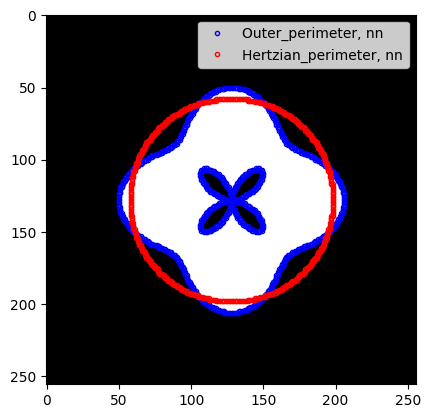

In [63]:
#With 256
sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

x, y = sphere.positions()
x -= sx / 2
y -= sy /2
radius = np.sqrt(x ** 2 + y ** 2)

theta_out = np.zeros((nx,ny))
#theta = np.arctan(y/x, out = theta_out, where = x!=0 )
theta = np.arctan2(y,x)
#h_m = 1/np.pi
substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
#r = np.sqrt((x*x)+(y*y))
#h_m = r*r/(2*R)
topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
amplitude = 0.2
radial_waves = Topography(amplitude*(np.cos(4*theta)), physical_sizes=(sx,sy))
topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

system1 = make_system(substrate, topography1)
system2 = make_system(substrate, topography)
gtol = 1e-6
penetration = 1.2
sol1 = system1.minimize_proxy(
    #initial_displacements=u_initial_guess,
    #logger=Logger("evaluations.log"),
    #logger=screen,
    offset=penetration,
)
sol2 = system2.minimize_proxy(
    #initial_displacements=u_initial_guess,
    #logger=Logger("evaluations.log"),
    #logger=screen,
    offset=penetration,
)
u = system1.displacements = sol1.x
gap = system1.compute_gap(u, penetration)

force = - system1.substrate.evaluate_force(u)
pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt
contact_area = np.where(pressures>0)

#With 256
contact_area1 = ~system1.contact_zone
contact_area2 = system2.contact_zone
Nx, Ny = contact_area1.shape
x,y = np.mgrid[:Nx, :Ny]
    
fig, ax = plt.subplots()
ax.imshow(contact_area1, cmap="Greys")
#iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
#ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    
oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nnn_stencil)
#oper[100:nx//2,100:ny//2]=False 
#oper[nx//2:160, ny//2:160] = False
#oper[100:nx//2, ny//2:160] = False
#oper[nx//2:160,100:ny//2]=False
sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nnn_stencil)
ax.plot(x[oper], y[oper], ".b", mfc="none",label="Outer_perimeter, nn")
ax.plot(x[sper], y[sper], ".r", mfc="none",label="Hertzian_perimeter, nn")
#oper = CAA.outer_perimeter_area(contact_area, False, stencil=CAA.nnn_stencil)
#ax.plot(x[oper], y[oper], "+b", label="outer_perimeter, nnn")
ax.legend()



In [36]:
CAA.coordination(contact_area1, False, stencil=CAA.nn_stencil)

array([[2, 3, 3, ..., 3, 3, 2],
       [3, 4, 4, ..., 4, 4, 3],
       [3, 4, 4, ..., 4, 4, 3],
       ...,
       [3, 4, 4, ..., 4, 4, 3],
       [3, 4, 4, ..., 4, 4, 3],
       [2, 3, 3, ..., 3, 3, 2]])

In [66]:
CAA.assign_patch_numbers_area(contact_area1,False)

(5,
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32))

In [64]:
CAA.assign_segment_numbers_area(contact_area1)

(340,
 array([[  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        [  3,   3,   3, ...,   3,   3,   3],
        ...,
        [338, 338, 338, ..., 338, 338, 338],
        [339, 339, 339, ..., 339, 339, 339],
        [340, 340, 340, ..., 340, 340, 340]], dtype=int32))